## Week 2: Dataset Acquisition and Preprocessing 

In [4]:
#install the libraries: 
### pytorch for python3.12

# brew install python@3.12
# python3.11 --version
# python3.11 -m venv venv
# source myenv/bin/activate
# pip install torch torchvision torchaudio

#verify the intallation 


In [5]:
import torch

In [6]:
print(torch.__version__)

2.6.0


In [7]:
# download the dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia 

In [8]:
#import the libraries 
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # always come together
import numpy as np

In [9]:
#upload the data
data_train = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train"
data_test = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/test"
data_val = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val"


In [10]:
# Define the transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [11]:
# How many images are in each folder for each class? 

import os

# Define the directories
data_dirs = {
    "Train": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train",
    "Test": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/test",
    "Validation": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val",
}

# Count the number of images in each subfolder (PNEUMONIA, NORMAL)
for category, path in data_dirs.items():
    print(f"\n{category} Set:")
    
    for class_name in ["PNEUMONIA", "NORMAL"]:  # Check specific folders
        class_path = os.path.join(path, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"  - {class_name}: {num_images} images")
        else:
            print(f"  - {class_name}: Folder not found")



Train Set:
  - PNEUMONIA: 3875 images
  - NORMAL: 1341 images

Test Set:
  - PNEUMONIA: 390 images
  - NORMAL: 234 images

Validation Set:
  - PNEUMONIA: 8 images
  - NORMAL: 8 images


Train Set:
  - PNEUMONIA: 3875 images
  - NORMAL: 1341 images

Test Set:
  - PNEUMONIA: 390 images
  - NORMAL: 234 images

Validation Set:
  - PNEUMONIA: 8 images
  - NORMAL: 8 images

# Adressing imbalance of the data in training set: 
imbalance would create an overfit toward the majority class
solutions:
1) downsample the majority class: downside - loss of information
2) oversample the minority class: 
3) class weight in loss function: modifies the loss function to assign a higher penalty to misclassifications of the minority class. 
        - should be done at the later stage.
        

In [12]:
# My choice is oversampling the minority class:
 
#load the libs
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import os
import random
from PIL import Image

# Load dataset (not yet transformed)
dataset = datasets.ImageFolder(root=data_train, transform=transform_train)


# Get class indices
class_indices = dataset.class_to_idx  # {'NORMAL': 0, 'PNEUMONIA': 1}
normal_idx = class_indices['NORMAL']
pneumonia_idx = class_indices['PNEUMONIA']

# Separate NORMAL and PNEUMONIA images
normal_images = [img_path for img_path, label in dataset.samples if label == normal_idx]
pneumonia_images = [img_path for img_path, label in dataset.samples if label == pneumonia_idx]

# Count images per class
num_normal = len(normal_images)
num_pneumonia = len(pneumonia_images)

print(f"Original count: NORMAL = {num_normal}, PNEUMONIA = {num_pneumonia}")


Original count: NORMAL = 1341, PNEUMONIA = 3875


In [13]:
# Oversample NORMAL images by randomly duplicating them
oversampled_normal_images = normal_images * (num_pneumonia // num_normal)  # Duplicate fully
oversampled_normal_images += random.sample(normal_images, num_pneumonia - len(oversampled_normal_images))  # Add remaining

In [14]:
# create the dataset for the train set(normal oversampled + pneumonia)

class OversampledDataset(Dataset):
    def __init__(self, normal_images, pneumonia_images, transform=None):
        self.image_paths = normal_images + pneumonia_images  # Merge both classes
        self.labels = [0] * len(normal_images) + [1] * len(pneumonia_images)  # Assign labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("L")  # 'L' mode is for grayscale (1 channel)
        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Create dataset
balanced_dataset = OversampledDataset(oversampled_normal_images, pneumonia_images, transform_train)

# Create DataLoader
train_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

# Verify batch distribution
num_normal_batch = sum(1 for _, labels in train_loader for label in labels if label == 0)
num_pneumonia_batch = sum(1 for _, labels in train_loader for label in labels if label == 1)

print(f"After Oversampling: NORMAL = {num_normal_batch}, PNEUMONIA = {num_pneumonia_batch}")


After Oversampling: NORMAL = 3875, PNEUMONIA = 3875


## Visualise a sample after preprocessing

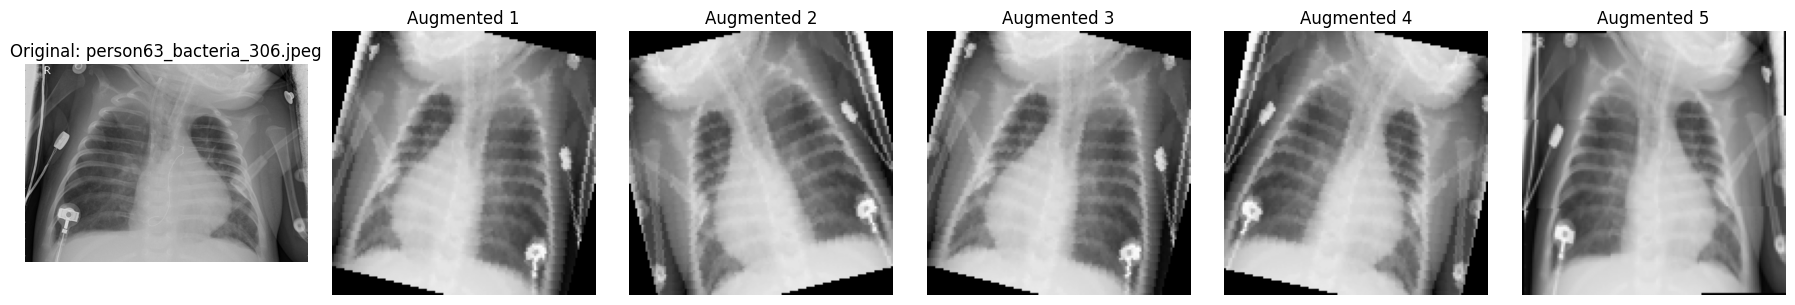

In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Path to a sample image in your dataset
img_path = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train/PNEUMONIA"
sample_img = os.listdir(img_path)[0]  # Get the first image in the directory

# Load the image
image = Image.open(os.path.join(img_path, sample_img))

# Convert to grayscale explicitly before applying transformations
image = image.convert('L')  # 'L' mode is for grayscale

# Define grayscale-compatible transformations (e.g., without color jitter)


# Apply the transformations to the image
augmented_images = [transform_train(image) for _ in range(5)]  # Apply the transformation 5 times to generate 5 augmented images

# Plot the original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # 6 subplots: 1 for the original and 5 for augmented images
axes[0].imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
axes[0].set_title(f"Original: {sample_img}")  # Display the original image name
axes[0].axis('off')  # Hide axis

for i, aug_img in enumerate(augmented_images):
    axes[i + 1].imshow(aug_img.permute(1, 2, 0), cmap='gray')  # Convert from CHW to HWC and apply 'gray' colormap
    axes[i + 1].set_title(f"Augmented {i + 1}")
    axes[i + 1].axis('off')  # Hide axis

plt.tight_layout()
plt.show()


In [16]:
# create data loader: 
val_dataset = datasets.ImageFolder(data_val, transform=transform_val)
test_dataset = datasets.ImageFolder(data_test, transform=transform_test)

# Create data loaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Week 3: Model Development
- Design a CNN architecture tailored for image classification.
- Train the model on the dataset with proper validation.
- Evaluate the model's performance using metrics like accuracy, precision, recall, and F1-score.
- Fine-tune the model for optimal performance.

Accuracy: Measures the overall correctness of the model.
Precision: Measures how many of the predicted positives are actually positive.
Recall: Measures how many of the actual positives are correctly identified.
F1 Score: Combines both precision and recall into a single metric.


In [17]:
import torch
import torch.nn as nn

class CNNClassifierGrayscale(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()               
        self.dropout = nn.Dropout(0.5)     

        # Compute fc1 input size
        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def _features(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        return x

    def _get_flattened_size(self):
        """Compute the flattened size after convolutions."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 128)
            dummy_output = self._features(dummy_input)
            return dummy_output.view(1, -1).size(1)

    def forward(self, x):
        if x is None:
            raise ValueError("Input tensor is None")
        x = self._features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)


In [18]:
#set the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

# Initialize model
model = CNNClassifierGrayscale().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8) #each 3rd step the learning will be updated by reducing its rate by 50%

## Training and Evaluation 

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import torch
from torchvision import transforms

num_epochs = 11
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_loss:.4f}')
    print(f'Training Accuracy: {epoch_accuracy:.4f}')
    print(f'Training Precision: {epoch_precision:.4f}')
    print(f'Training Recall: {epoch_recall:.4f}')
    print(f'Training F1 Score: {epoch_f1:.4f}')

    model.eval()
    val_loss, all_val_preds, all_val_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader.dataset)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, average='macro')
    val_recall = recall_score(all_val_labels, all_val_preds, average='macro')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')
# Step the scheduler to update the learning rate
    scheduler.step()


        # Print the current learning rate after stepping the scheduler
    current_lr = scheduler.get_last_lr()[0]  # Since we only have one parameter group
    print(f'Current Learning Rate: {current_lr:.6f}')

100%|██████████| 243/243 [02:38<00:00,  1.53it/s]


Epoch [1/11]
Training Loss: 0.3375
Training Accuracy: 0.8883
Training Precision: 0.8883
Training Recall: 0.8883
Training F1 Score: 0.8883
Validation Loss: 0.4456
Validation Accuracy: 0.8157
Validation Precision: 0.8219
Validation Recall: 0.7791
Validation F1 Score: 0.7914
Current Learning Rate: 0.001000


100%|██████████| 243/243 [02:39<00:00,  1.53it/s]


Epoch [2/11]
Training Loss: 0.1642
Training Accuracy: 0.9394
Training Precision: 0.9394
Training Recall: 0.9394
Training F1 Score: 0.9394
Validation Loss: 0.3315
Validation Accuracy: 0.8510
Validation Precision: 0.8500
Validation Recall: 0.8278
Validation F1 Score: 0.8363
Current Learning Rate: 0.001000


100%|██████████| 243/243 [02:39<00:00,  1.52it/s]


Epoch [3/11]
Training Loss: 0.1392
Training Accuracy: 0.9497
Training Precision: 0.9497
Training Recall: 0.9497
Training F1 Score: 0.9497
Validation Loss: 0.4290
Validation Accuracy: 0.8333
Validation Precision: 0.8611
Validation Recall: 0.7889
Validation F1 Score: 0.8061
Current Learning Rate: 0.001000


100%|██████████| 243/243 [02:39<00:00,  1.52it/s]


Epoch [4/11]
Training Loss: 0.1314
Training Accuracy: 0.9510
Training Precision: 0.9510
Training Recall: 0.9510
Training F1 Score: 0.9510
Validation Loss: 0.3717
Validation Accuracy: 0.8462
Validation Precision: 0.8477
Validation Recall: 0.8197
Validation F1 Score: 0.8297
Current Learning Rate: 0.001000


100%|██████████| 243/243 [02:39<00:00,  1.53it/s]


Epoch [5/11]
Training Loss: 0.1177
Training Accuracy: 0.9585
Training Precision: 0.9585
Training Recall: 0.9585
Training F1 Score: 0.9585
Validation Loss: 0.4893
Validation Accuracy: 0.8109
Validation Precision: 0.8579
Validation Recall: 0.7547
Validation F1 Score: 0.7719
Current Learning Rate: 0.000800


100%|██████████| 243/243 [02:45<00:00,  1.47it/s]


Epoch [6/11]
Training Loss: 0.1029
Training Accuracy: 0.9650
Training Precision: 0.9651
Training Recall: 0.9650
Training F1 Score: 0.9650
Validation Loss: 0.9580
Validation Accuracy: 0.7500
Validation Precision: 0.8355
Validation Recall: 0.6701
Validation F1 Score: 0.6722
Current Learning Rate: 0.000800


100%|██████████| 243/243 [02:44<00:00,  1.48it/s]


Epoch [7/11]
Training Loss: 0.0969
Training Accuracy: 0.9644
Training Precision: 0.9644
Training Recall: 0.9644
Training F1 Score: 0.9644
Validation Loss: 0.6225
Validation Accuracy: 0.8301
Validation Precision: 0.8727
Validation Recall: 0.7795
Validation F1 Score: 0.7983
Current Learning Rate: 0.000800


100%|██████████| 243/243 [02:43<00:00,  1.48it/s]


Epoch [8/11]
Training Loss: 0.0913
Training Accuracy: 0.9667
Training Precision: 0.9667
Training Recall: 0.9667
Training F1 Score: 0.9667
Validation Loss: 0.5479
Validation Accuracy: 0.8237
Validation Precision: 0.8588
Validation Recall: 0.7744
Validation F1 Score: 0.7919
Current Learning Rate: 0.000800


100%|██████████| 243/243 [02:42<00:00,  1.50it/s]


Epoch [9/11]
Training Loss: 0.0866
Training Accuracy: 0.9675
Training Precision: 0.9675
Training Recall: 0.9675
Training F1 Score: 0.9675
Validation Loss: 0.5727
Validation Accuracy: 0.8157
Validation Precision: 0.8558
Validation Recall: 0.7628
Validation F1 Score: 0.7801
Current Learning Rate: 0.000800


100%|██████████| 243/243 [02:42<00:00,  1.49it/s]


Epoch [10/11]
Training Loss: 0.0869
Training Accuracy: 0.9665
Training Precision: 0.9665
Training Recall: 0.9665
Training F1 Score: 0.9665
Validation Loss: 0.7411
Validation Accuracy: 0.7837
Validation Precision: 0.8546
Validation Recall: 0.7150
Validation F1 Score: 0.7276
Current Learning Rate: 0.000640


100%|██████████| 243/243 [02:41<00:00,  1.50it/s]


Epoch [11/11]
Training Loss: 0.0782
Training Accuracy: 0.9726
Training Precision: 0.9727
Training Recall: 0.9726
Training F1 Score: 0.9726
Validation Loss: 0.7271
Validation Accuracy: 0.8205
Validation Precision: 0.8694
Validation Recall: 0.7658
Validation F1 Score: 0.7842
Current Learning Rate: 0.000640


Precision, Recall, F1-Score: These metrics provide a deeper understanding of model performance, especially in imbalanced datasets where accuracy might be misleading.

## Fine tuning the hyperparameters

1. Adjusting the learning rate for the optimizer.
2. Adding regularization such as dropout or L2 regularization.
3. Using data augmentation to prevent overfitting.
4. Early stopping to prevent training for too long and avoid overfitting.

In [21]:
# Single Image Prediction with CNN for Pneumonia Detection
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model.eval()  # Set to evaluation mode

def predict_image(image_path, model, device):
    # Define image transformations (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)
    
    return 'PNEUMONIA' if predicted_class.item() == 1 else 'NORMAL'

# Example usage
image_path = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
result = predict_image(image_path, model, device)
print(f"Predicted Class: {result}")


Predicted Class: PNEUMONIA


In [22]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F  # For softmax

# Load the trained model
model.eval()  # Set to evaluation mode

def predict_image_with_confidence(image_path, model, device):
    # Define image transformations (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        output = model(image)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(output, dim=1)
        
        # Get the predicted class and the confidence score (max probability)
        predicted_class = torch.argmax(probabilities, dim=1)
        confidence_score = torch.max(probabilities)
    
    # Map the predicted class to the label
    predicted_label = 'PNEUMONIA' if predicted_class.item() == 1 else 'NORMAL'
    
    return predicted_label, confidence_score.item()

# Example usage
image_path = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
predicted_class, confidence = predict_image_with_confidence(image_path, model, device)
print(f"Predicted Class: {predicted_class} with Confidence: {confidence:.4f}")


Predicted Class: PNEUMONIA with Confidence: 0.9999


In [23]:
import torch
import torch.nn.functional as F  # For softmax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_loss = 0.0
all_test_preds = []
all_test_labels = []
all_confidences = []  # To store the confidence scores for each prediction

# Disable gradient calculations for testing
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)
        
        # Get predictions and confidence scores
        _, predicted = torch.max(probabilities, 1)
        max_confidence, _ = torch.max(probabilities, 1)  # Confidence is the highest probability
        
        # Append to lists
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        all_confidences.extend(max_confidence.cpu().numpy())

# Calculate average test loss
test_loss /= len(val_loader.dataset)

# Calculate test metrics
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds, average='macro')
test_recall = recall_score(all_test_labels, all_test_preds, average='macro')
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')

# Confidence metrics: Mean and standard deviation of confidence scores
mean_confidence = np.mean(all_confidences)
std_confidence = np.std(all_confidences)

# Print the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Mean Confidence Score: {mean_confidence:.4f}')
print(f'Standard Deviation of Confidence Scores: {std_confidence:.4f}')


Test Loss: 0.3668
Test Accuracy: 0.8750
Test Precision: 0.9000
Test Recall: 0.8750
Test F1 Score: 0.8730
Mean Confidence Score: 0.8803
Standard Deviation of Confidence Scores: 0.1313


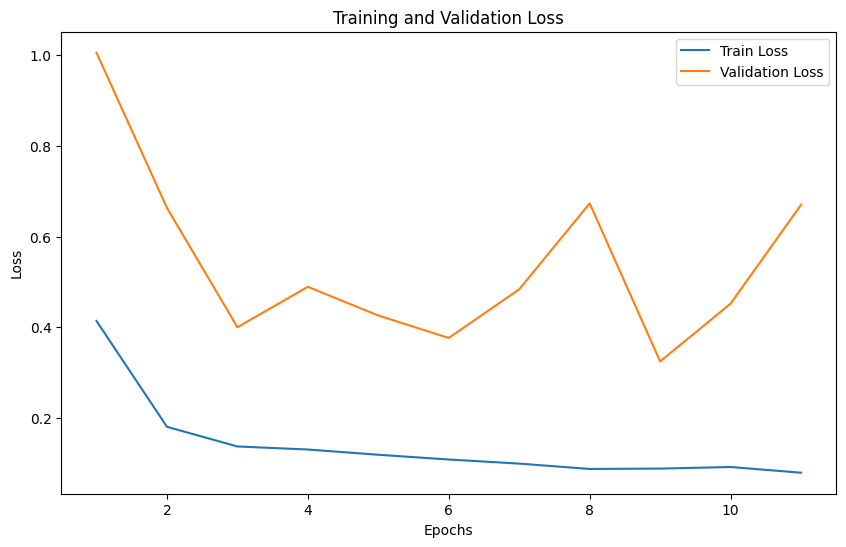

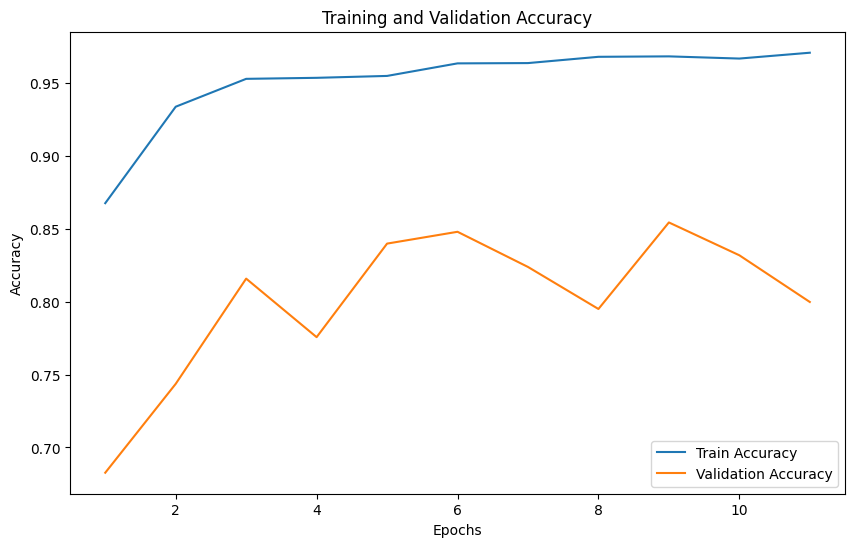

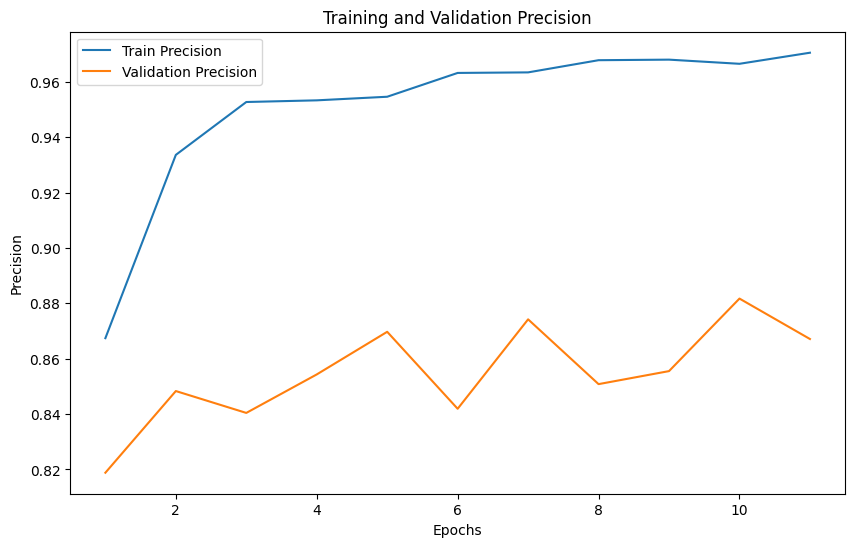

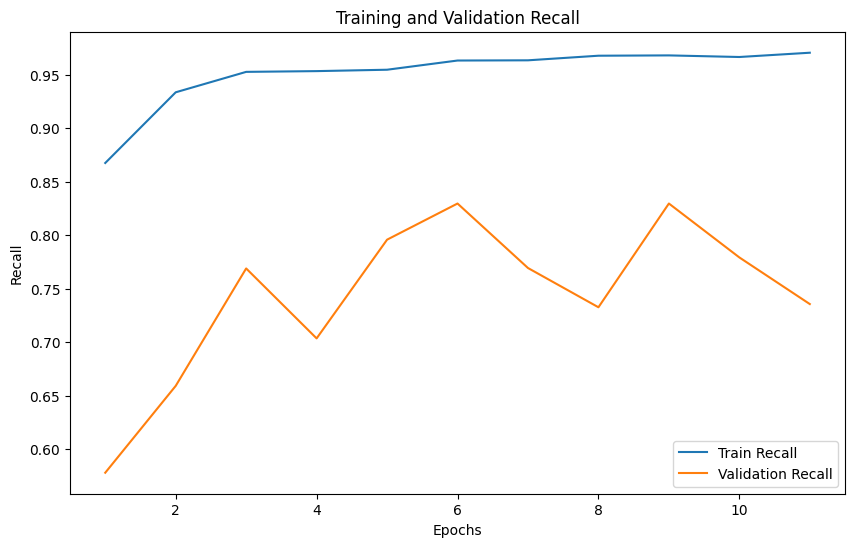

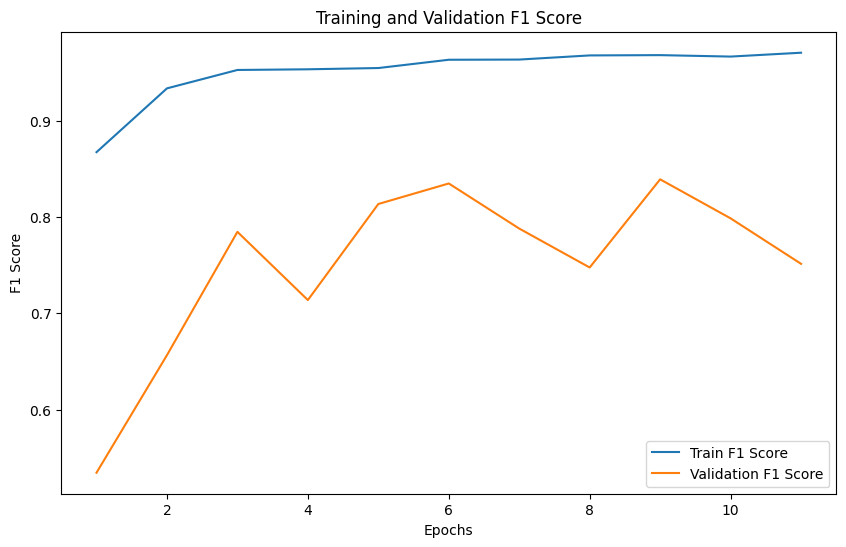

In [24]:
# Plot the metrics

# import matplotlib.pyplot as plt

# Manually input the results you provided
train_losses = [0.4141, 0.1808, 0.1375, 0.1307, 0.1192, 0.1087, 0.0997, 0.0879, 0.0887, 0.0922, 0.0796]
train_accuracies = [0.8674, 0.9335, 0.9526, 0.9533, 0.9546, 0.9632, 0.9634, 0.9677, 0.9680, 0.9665, 0.9705]
train_precisions = [0.8674, 0.9336, 0.9527, 0.9533, 0.9546, 0.9632, 0.9634, 0.9678, 0.9680, 0.9665, 0.9705]
train_recalls = [0.8674, 0.9335, 0.9526, 0.9533, 0.9546, 0.9632, 0.9634, 0.9677, 0.9680, 0.9665, 0.9705]
train_f1_scores = [0.8673, 0.9335, 0.9526, 0.9533, 0.9546, 0.9632, 0.9634, 0.9677, 0.9680, 0.9665, 0.9705]

val_losses = [1.0051, 0.6633, 0.4002, 0.4893, 0.4260, 0.3766, 0.4838, 0.6732, 0.3248, 0.4522, 0.6699]
val_accuracies = [0.6827, 0.7436, 0.8157, 0.7756, 0.8397, 0.8478, 0.8237, 0.7949, 0.8542, 0.8317, 0.7997]
val_precisions = [0.8188, 0.8483, 0.8404, 0.8543, 0.8697, 0.8419, 0.8742, 0.8508, 0.8555, 0.8817, 0.8671]
val_recalls = [0.5778, 0.6590, 0.7688, 0.7034, 0.7957, 0.8295, 0.7692, 0.7325, 0.8295, 0.7791, 0.7355]
val_f1_scores = [0.5346, 0.6566, 0.7846, 0.7138, 0.8135, 0.8348, 0.7880, 0.7476, 0.8391, 0.7986, 0.7514]

# Number of epochs
epochs = list(range(1, len(train_losses) + 1))

# Plotting the training and validation metrics

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Precision plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

# Recall plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

# F1 score plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.show()


In [25]:
#save the model 
import torch
torch.save(model.state_dict(), "../../web-app/cholpon-zhakshylykova/model.pth")
